In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math


from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [12]:
start = "2009-01-01"
end = '2019-1-01'
coke = yf.download('KO',start,end)

new_start = '2018-10-19'
new_end = '2020-1-01'
new_coke = yf.download('KO',new_start,new_end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [14]:
def rolling_mean(data):
    data['MA50'] = data['Open'].rolling(50).mean()
    data['Open'].plot(figsize = (15,7))
    data['MA50'].plot()
    plt.legend()

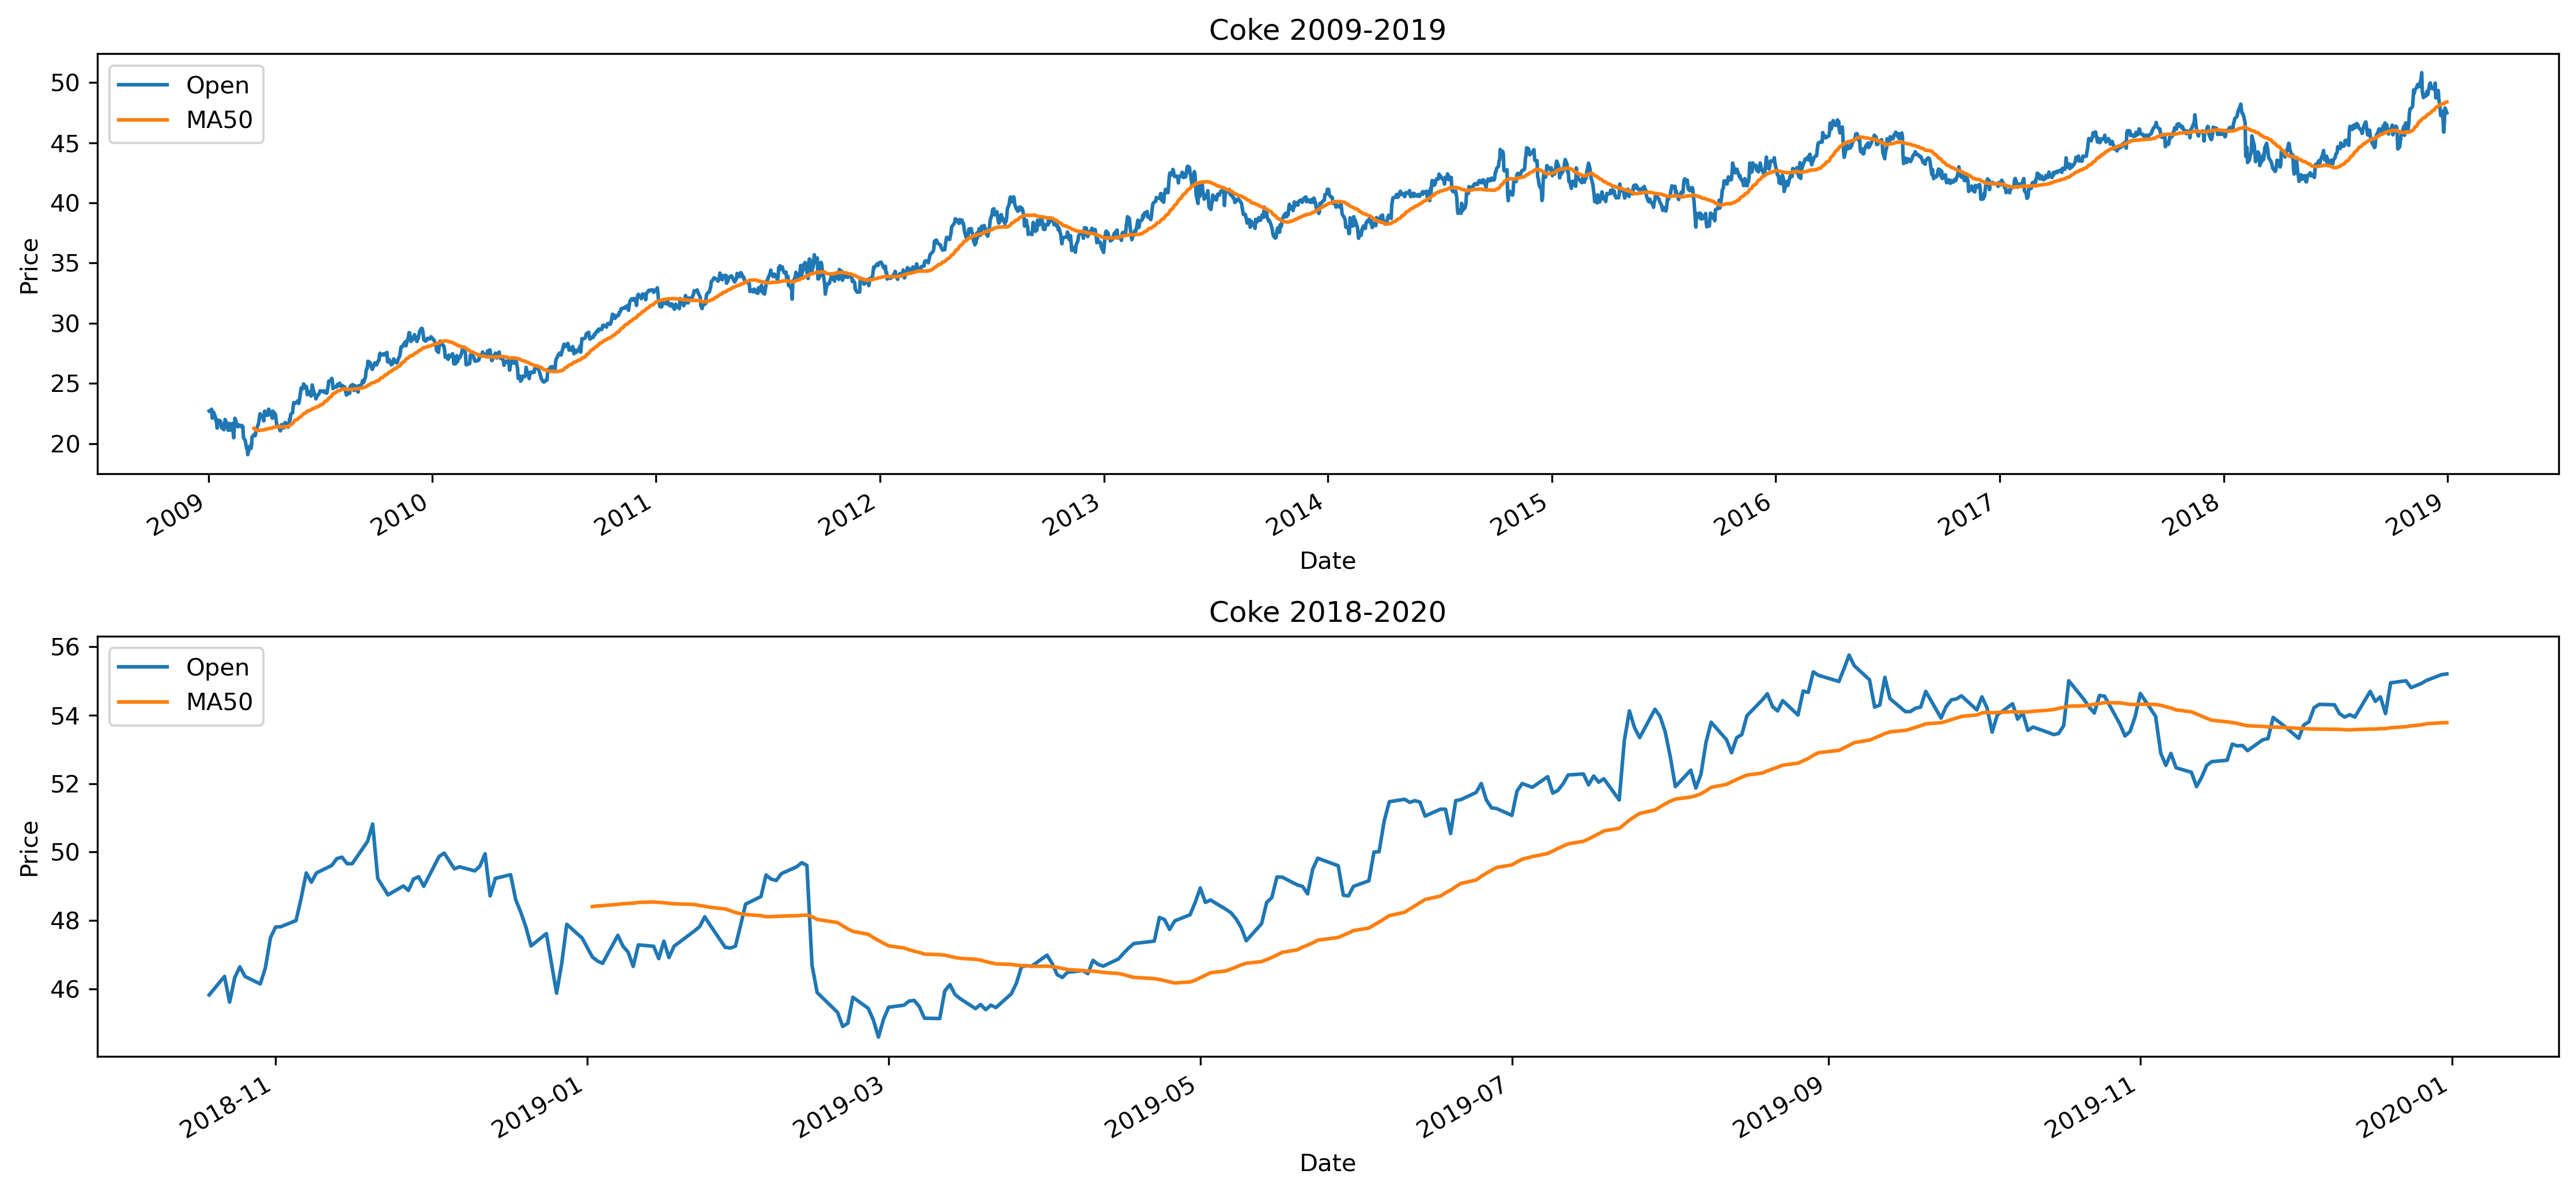

In [15]:
plt.figure(dpi=300)
plt.subplot(2,1,1)
rolling_mean(coke)
plt.title('Coke 2009-2019')
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(2,1,2)
rolling_mean(new_coke)
plt.title('Coke 2018-2020')
plt.xlabel('Date')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

In [16]:
new_coke.iloc[:50, new_coke.columns.get_loc('MA50')] = coke['MA50'].tail(50).values
coke['MA50'].fillna(coke.at[coke['MA50'].first_valid_index(), 'MA50'], inplace=True)

In [51]:
def ARIMA_Function(data, title, new_data):
    # Split data into training and testing sets
    train_size = int(len(data) * 0.9)
    train, test = data[:train_size], data[train_size:]

    # Find the best ARIMA model parameters using auto_arima
    auto_model = auto_arima(train['MA50'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    best_order = auto_model.order

    # Define function to evaluate ARIMA model
    def evaluate_arima_model(train, test, order):
        history = [x for x in train['MA50']]
        predictions = []
        for t in range(len(test)):
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test['MA50'].iloc[t])
        error = mean_squared_error(test['MA50'], predictions)
        return error, predictions

    # Evaluate the ARIMA model with the best parameters
    error, predictions = evaluate_arima_model(train, test, best_order)

    # Train the ARIMA model with the best parameters on the full dataset
    model = ARIMA(data['MA50'], order=best_order)
    model_fit = model.fit()

    # Forecast next year of stock prices
    forecast = model_fit.forecast(steps=365)

    # Plotting
    plt.figure(figsize=(12, 6), dpi=300)
    # plt.subplot(2, 1, 1)
    plt.plot(new_data.index, new_data['MA50'], label='True Future Data', color='#ba432e')
    plt.plot(data.index, data['MA50'], label='Historical Data', color='black')
    plt.plot(pd.date_range(start=data.index[-1], periods=366, freq='D')[1:], forecast, color='red', label='Forecast')
    plt.title('Stock Price Forecast with ARIMA for ' + title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    # plt.show()

    # Plot the error and the predictions
    # plt.figure(figsize=(12, 6), dpi=300)
    # plt.subplot(2, 1, 2)
    # plt.plot(test.index, test['MA50'], label='True Future Data', color='#ba432e')
    # plt.plot(test.index, predictions, label='Predictions', color='black')
    # plt.title('ARIMA Model Evaluation for ' + title)
    # plt.xlabel('Date')
    # plt.ylabel('Stock Price')
    # plt.legend()
    # plt.grid(True)

    plt.tight_layout()
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-14614.840, Time=2.98 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-14614.126, Time=0.83 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-14619.359, Time=1.14 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-14619.441, Time=2.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-14616.124, Time=0.82 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-14617.515, Time=0.89 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-14617.494, Time=0.74 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-14615.679, Time=1.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-14621.441, Time=0.60 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-14619.515, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-14619.495, Time=0.38 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-14621.358, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-14617.680, Time=0.24 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 12.098 sec

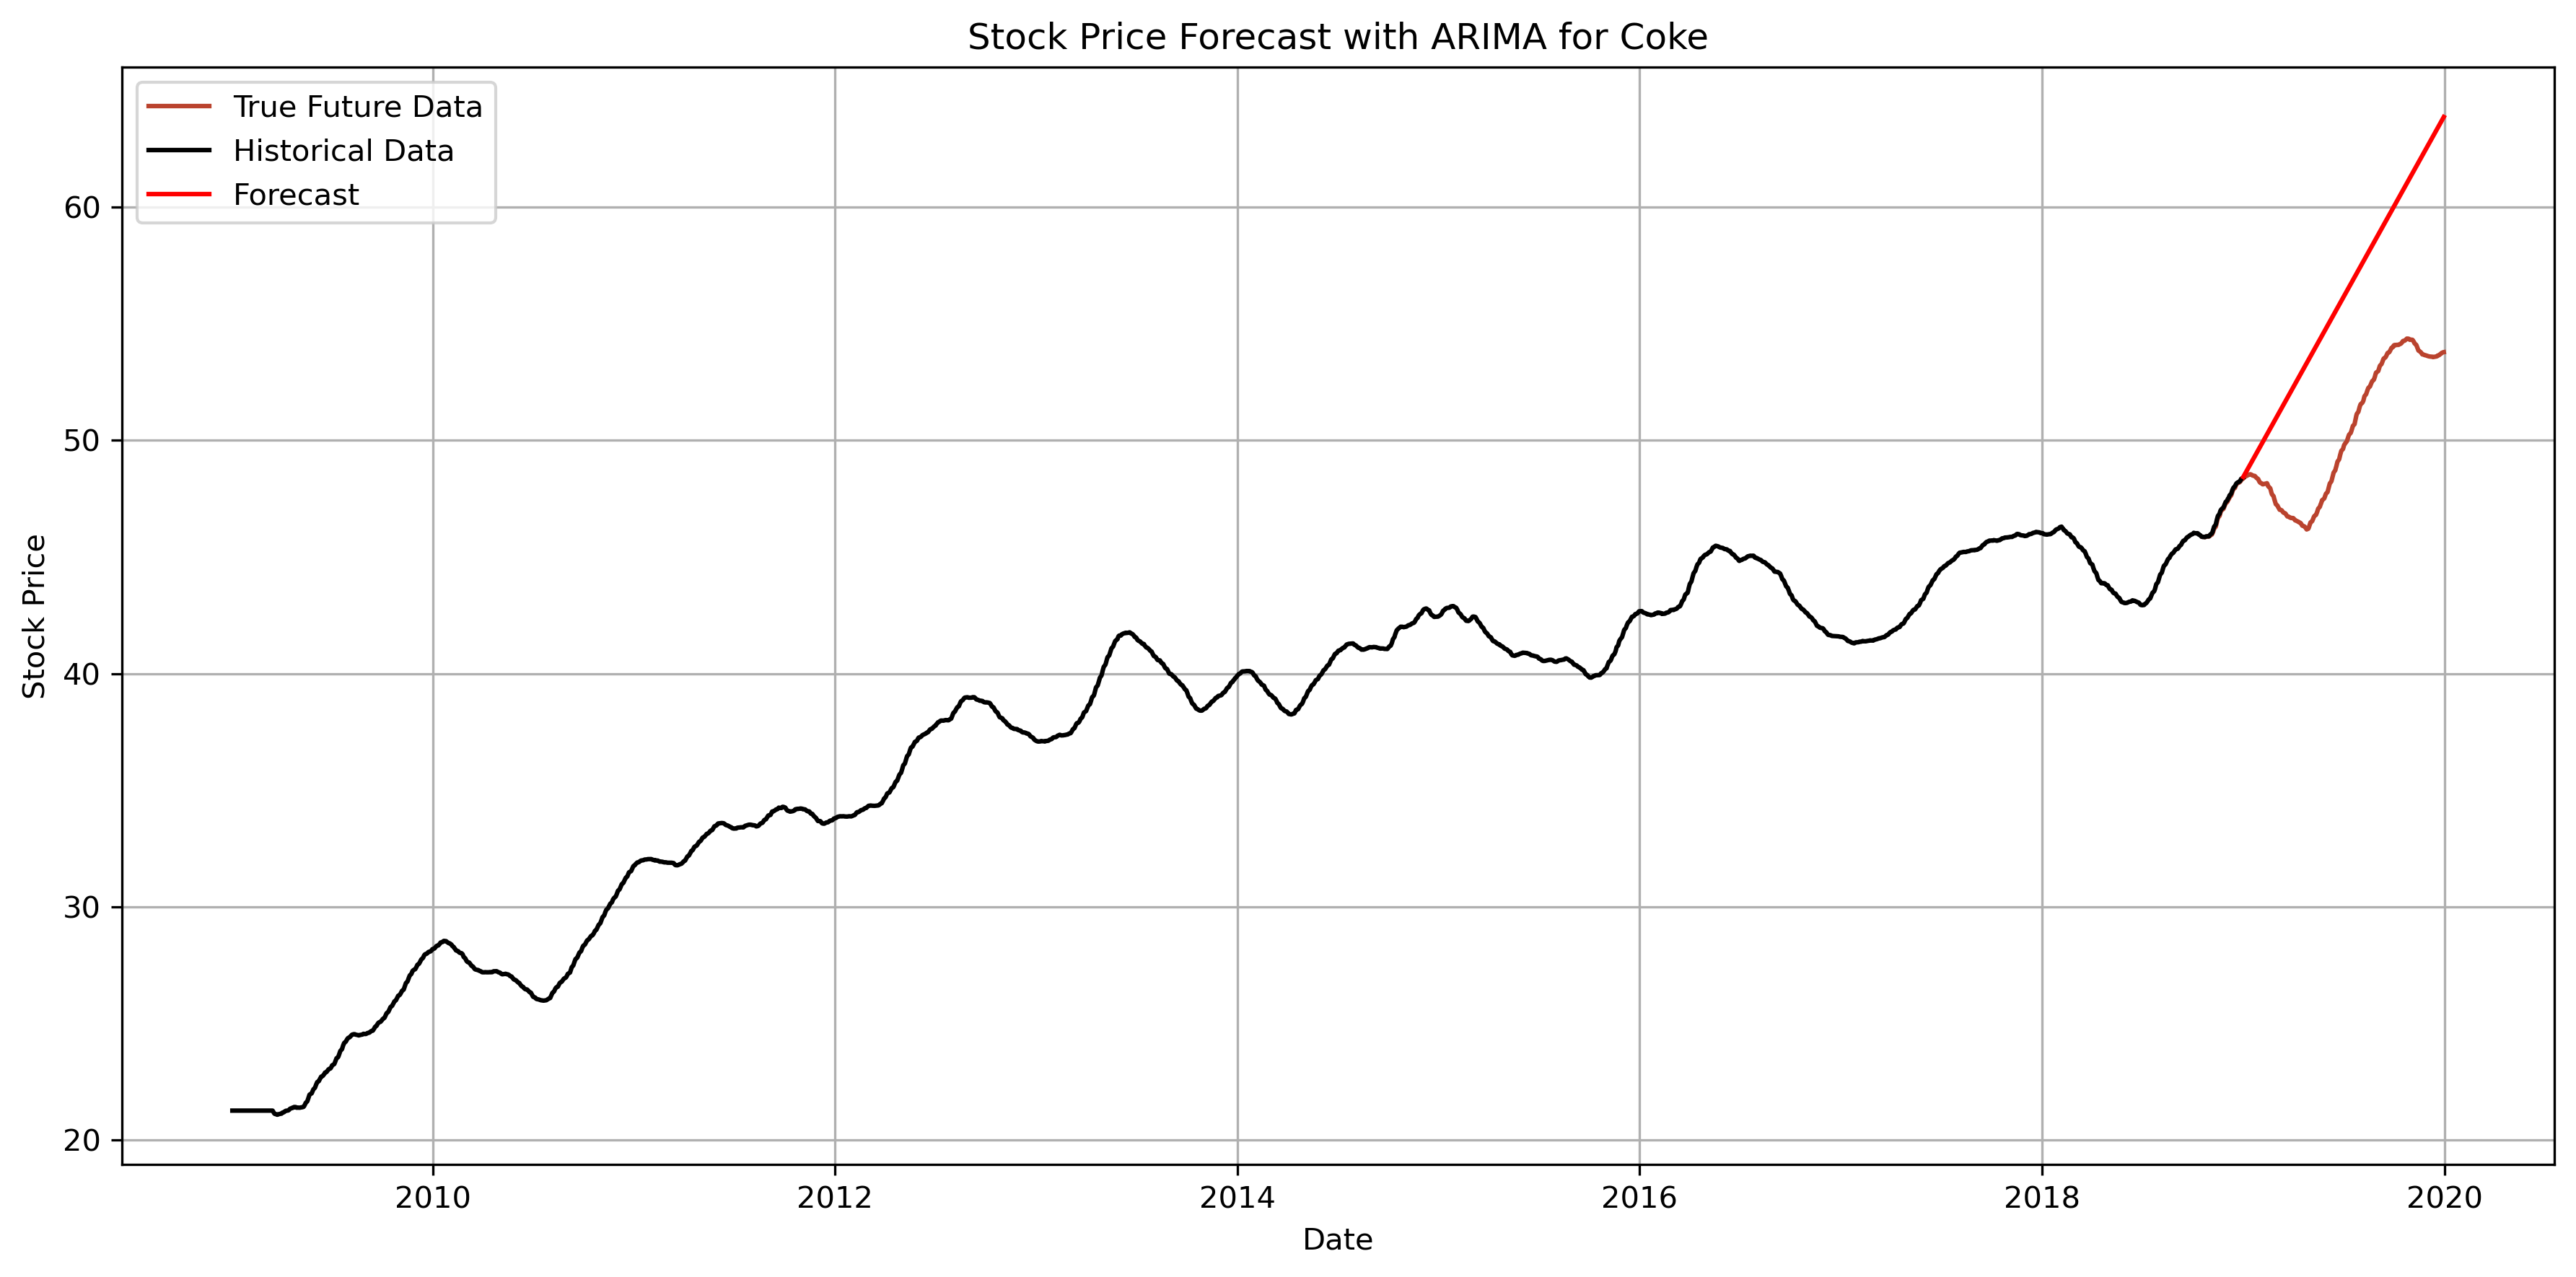

In [52]:
ARIMA_Function(coke, 'Coke', new_coke)

In [47]:
def SVM_Function(data, title, new_data):
    # Split data into training and testing sets
    train_size = int(len(data) * 0.9)
    train, test = data[:train_size], data[train_size:]

    # Train Support Vector Machine model
    svm_model = SVR(kernel='rbf')
    svm_model.fit(train.index.to_numpy().reshape(-1, 1), train['MA50'])

    # Predict using SVM model
    predictions = svm_model.predict(test.index.to_numpy().reshape(-1, 1))

    # Evaluate SVM model
    error = mean_squared_error(test['MA50'], predictions)

    # Forecast next year of stock prices
    forecast = svm_model.predict(pd.date_range(start=data.index[-1], periods=365, freq='D').to_numpy().reshape(-1, 1))

    # Band-aid fix to make the forecast continuous
    temp = data["MA50"].iloc[-1] - forecast[0]
    forecast = forecast + temp


    # Plotting
    plt.figure(figsize=(12, 6), dpi=300)
    plt.plot(new_data.index, new_data['MA50'], label='True Future Data', color='#ba432e')
    plt.plot(data.index, data['MA50'], label='Historical Data', color='black')
    plt.plot(pd.date_range(start=data.index[-1], periods=366, freq='D')[1:], forecast, color='red', label='Forecast')
    plt.title('Stock Price Forecast with SVM for ' + title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

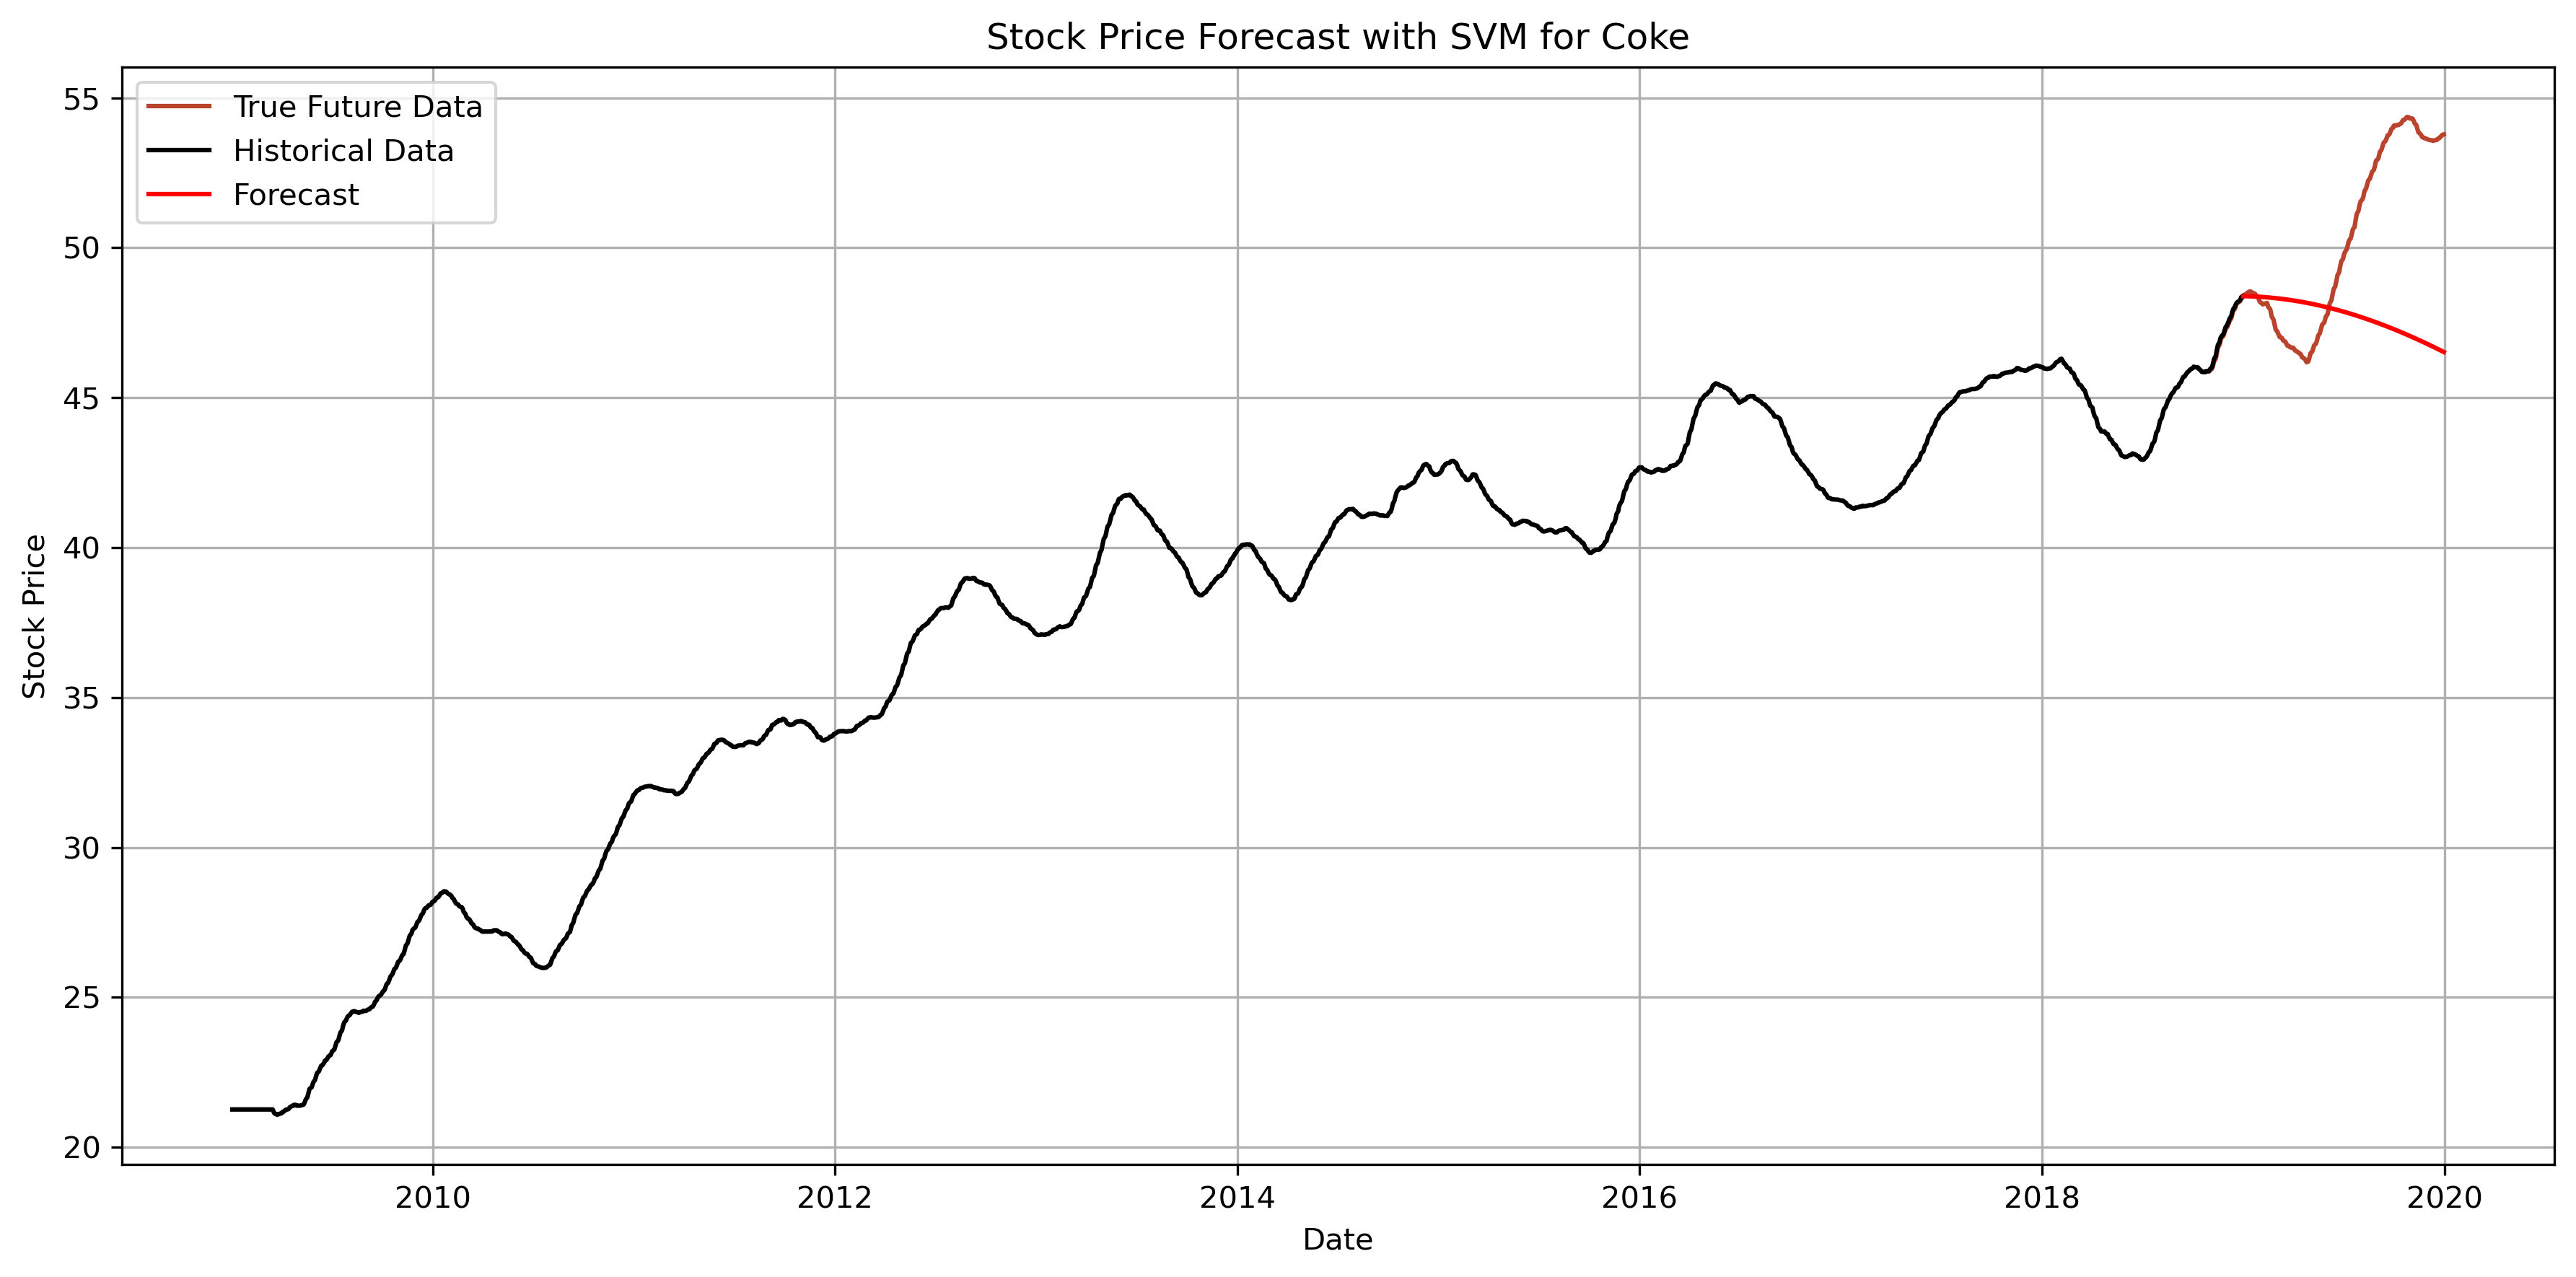

In [48]:
SVM_Function(coke, 'Coke', new_coke)

In [56]:
def KNN_Function(data, title, new_data):
    # Split data into training and testing sets
    train_size = int(len(data) * 0.9)
    train, test = data[:train_size], data[train_size:]

    # Train K-Nearest Neighbors model
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(train.index.to_numpy().reshape(-1, 1), train['MA50'])

    # Predict using KNN model
    predictions = knn_model.predict(test.index.to_numpy().reshape(-1, 1))

    # Evaluate KNN model
    error = mean_squared_error(test['MA50'], predictions)

    # Forecast next year of stock prices
    forecast = knn_model.predict(pd.date_range(start=data.index[-1], periods=365, freq='D').to_numpy().reshape(-1, 1))

    # Band-aid fix for KNN model
    temp = data["MA50"].iloc[-1] - forecast[0]
    forecast = forecast + temp

    # Plotting
    plt.figure(figsize=(12, 6), dpi=300)
    plt.plot(new_data.index, new_data['MA50'], label='True Future Data', color='#ba432e')
    plt.plot(data.index, data['MA50'], label='Historical Data', color='black')
    plt.plot(pd.date_range(start=data.index[-1], periods=366, freq='D')[1:], forecast, color='red', label='Forecast')
    plt.title('Stock Price Forecast with KNN for ' + title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


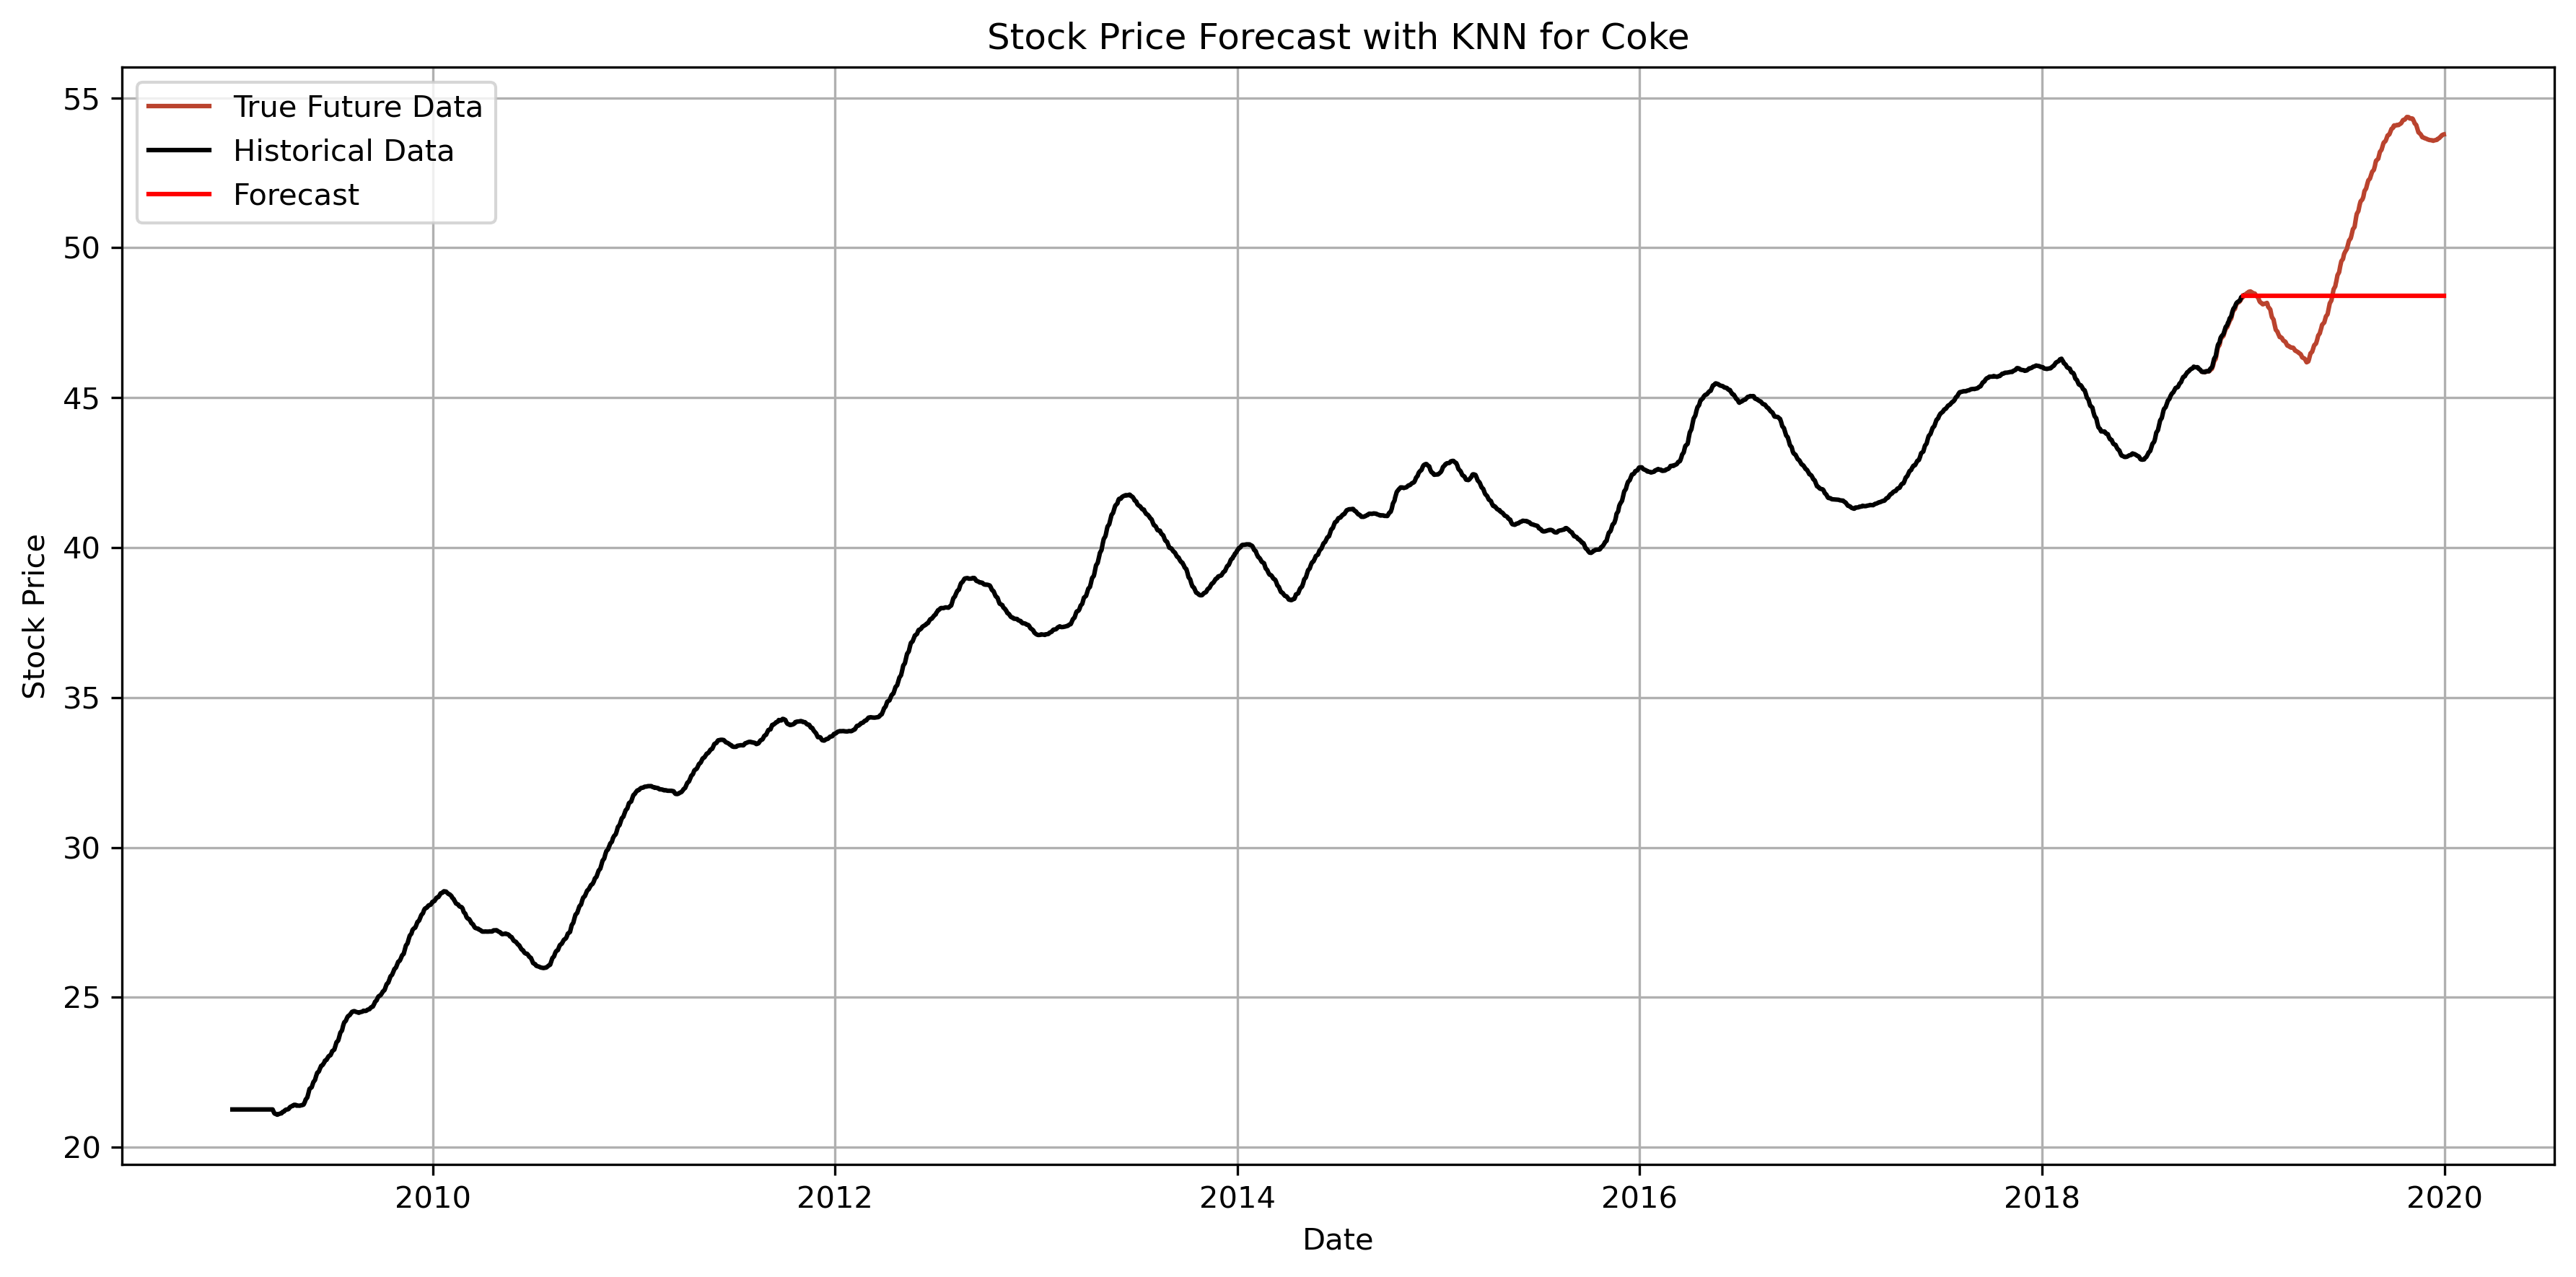

In [57]:
KNN_Function(coke, 'Coke', new_coke)

In [62]:
train_data, test_data = coke, new_coke

train_arima = train_data['Open']
test_arima = test_data['Open']


history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

In [63]:
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

In [64]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 0.24235381379814408
MAE: 0.36121360680504117
RMSE: 0.4922944381141677


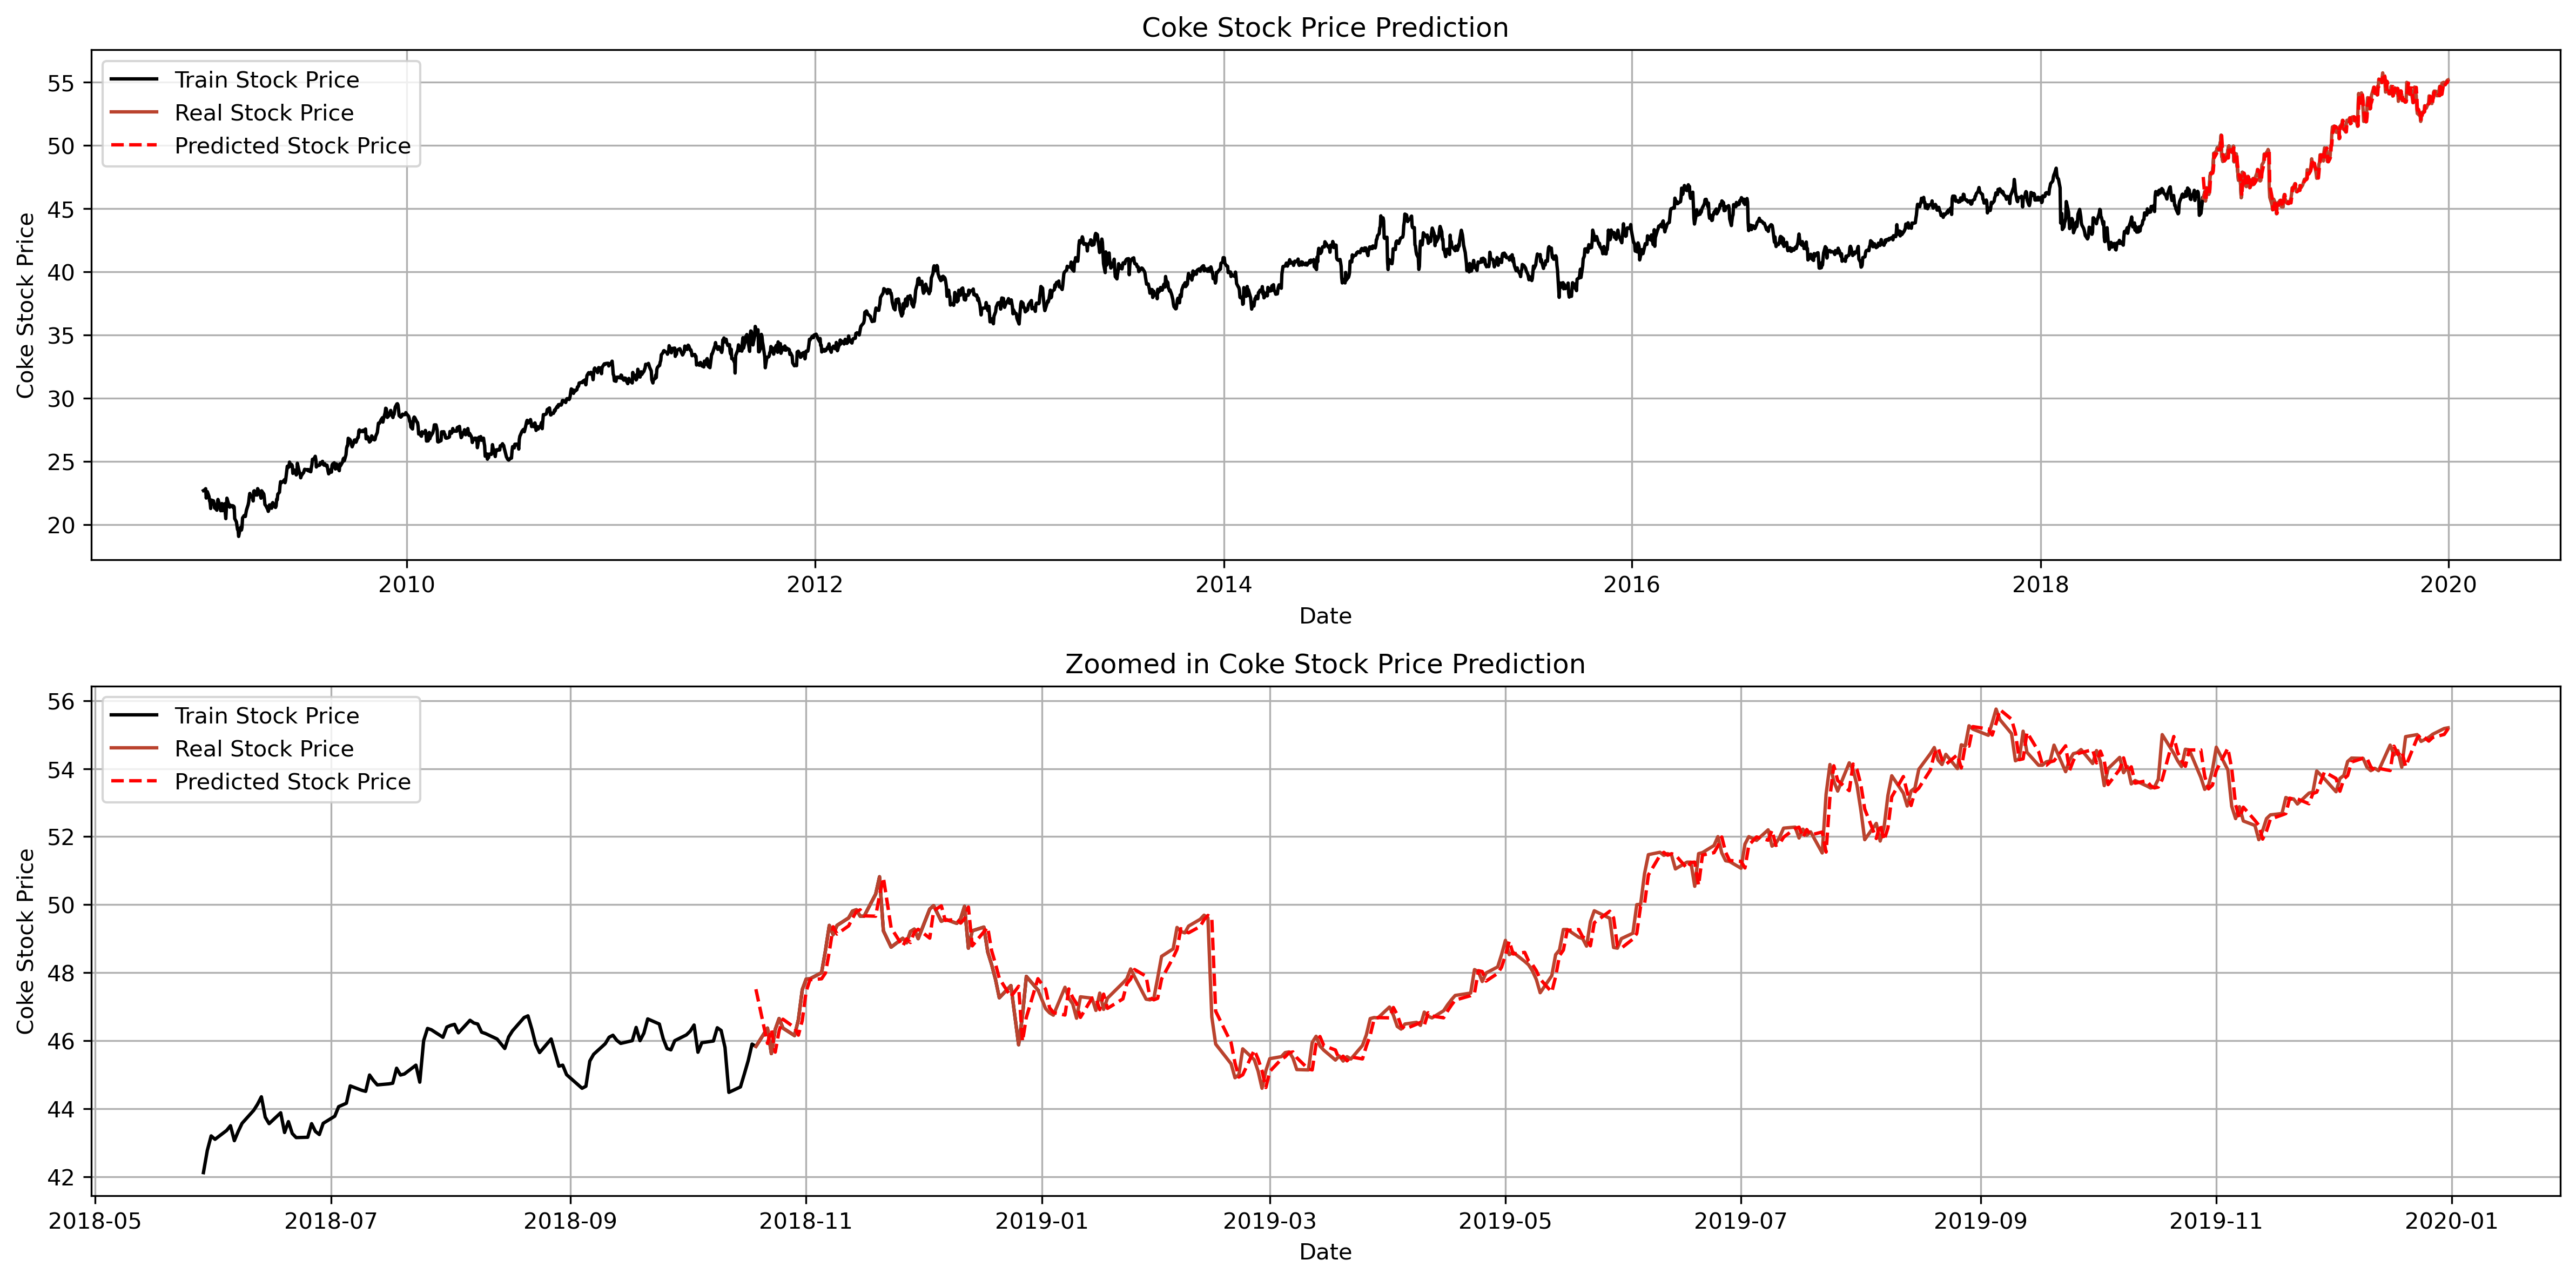

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8), dpi=300)
plt.subplot(2, 1, 1)
plt.plot(coke.index[-3285:], coke['Open'].tail(3285), label = 'Train Stock Price', color='black')
plt.plot(test_data.index, y, label = 'Real Stock Price', color='#ba432e')
plt.plot(test_data.index, predictions, color = 'red', label = 'Predicted Stock Price', linestyle='dashed')
plt.title('Coke Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Coke Stock Price')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(coke.index[-150:], coke['Open'].tail(150), label = 'Train Stock Price', color='black')
plt.plot(test_data.index, y, label = 'Real Stock Price', color='#ba432e')
plt.plot(test_data.index, predictions, color = 'red', label = 'Predicted Stock Price', linestyle='dashed')
plt.title('Zoomed in Coke Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Coke Stock Price')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

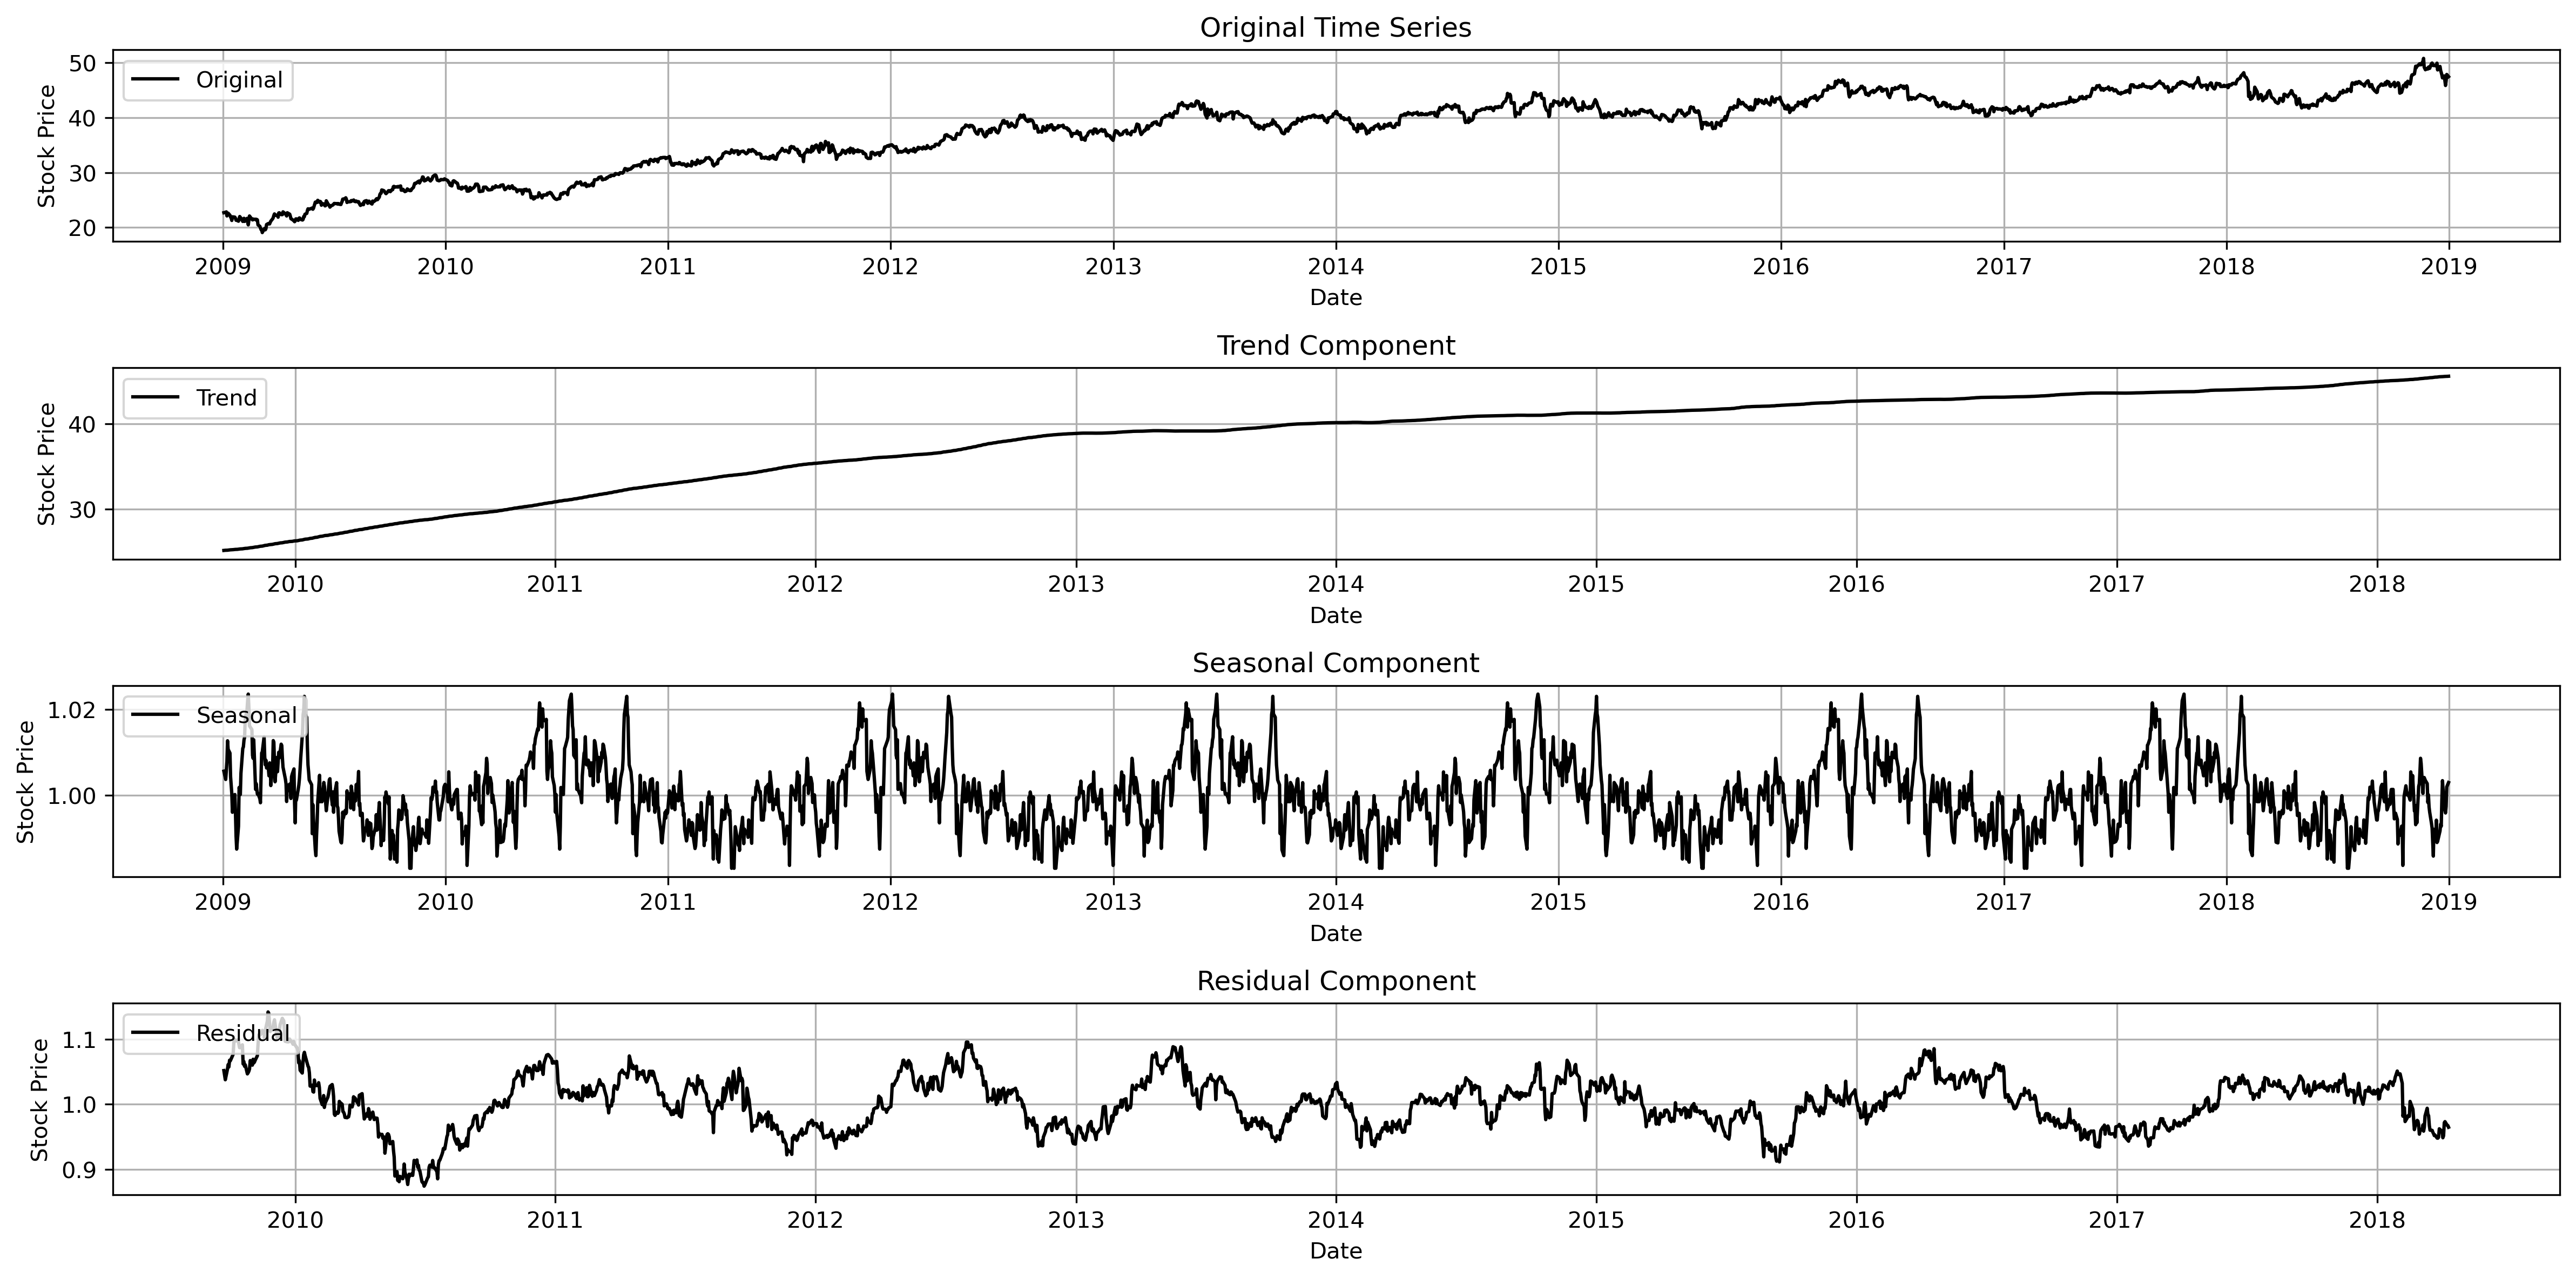

In [73]:
decomposition = seasonal_decompose(coke['Open'], model='multiplicative', period=365)
# plot the decomposition
plt.figure(figsize=(16,8), dpi=300)
plt.subplot(4, 1, 1)
plt.plot(coke['Open'], label='Original', color='black')
plt.legend(loc='upper left')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='black')
plt.legend(loc='upper left')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='black')
plt.legend(loc='upper left')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='black')
plt.legend(loc='upper left')
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)

plt.tight_layout()
plt.show()

Mean Absolute Error:  0.14309609314752003
Mean Squared Error:  0.03796335336127785
R-squared:  0.9991326481987525
OOB score:  0.999327531996385


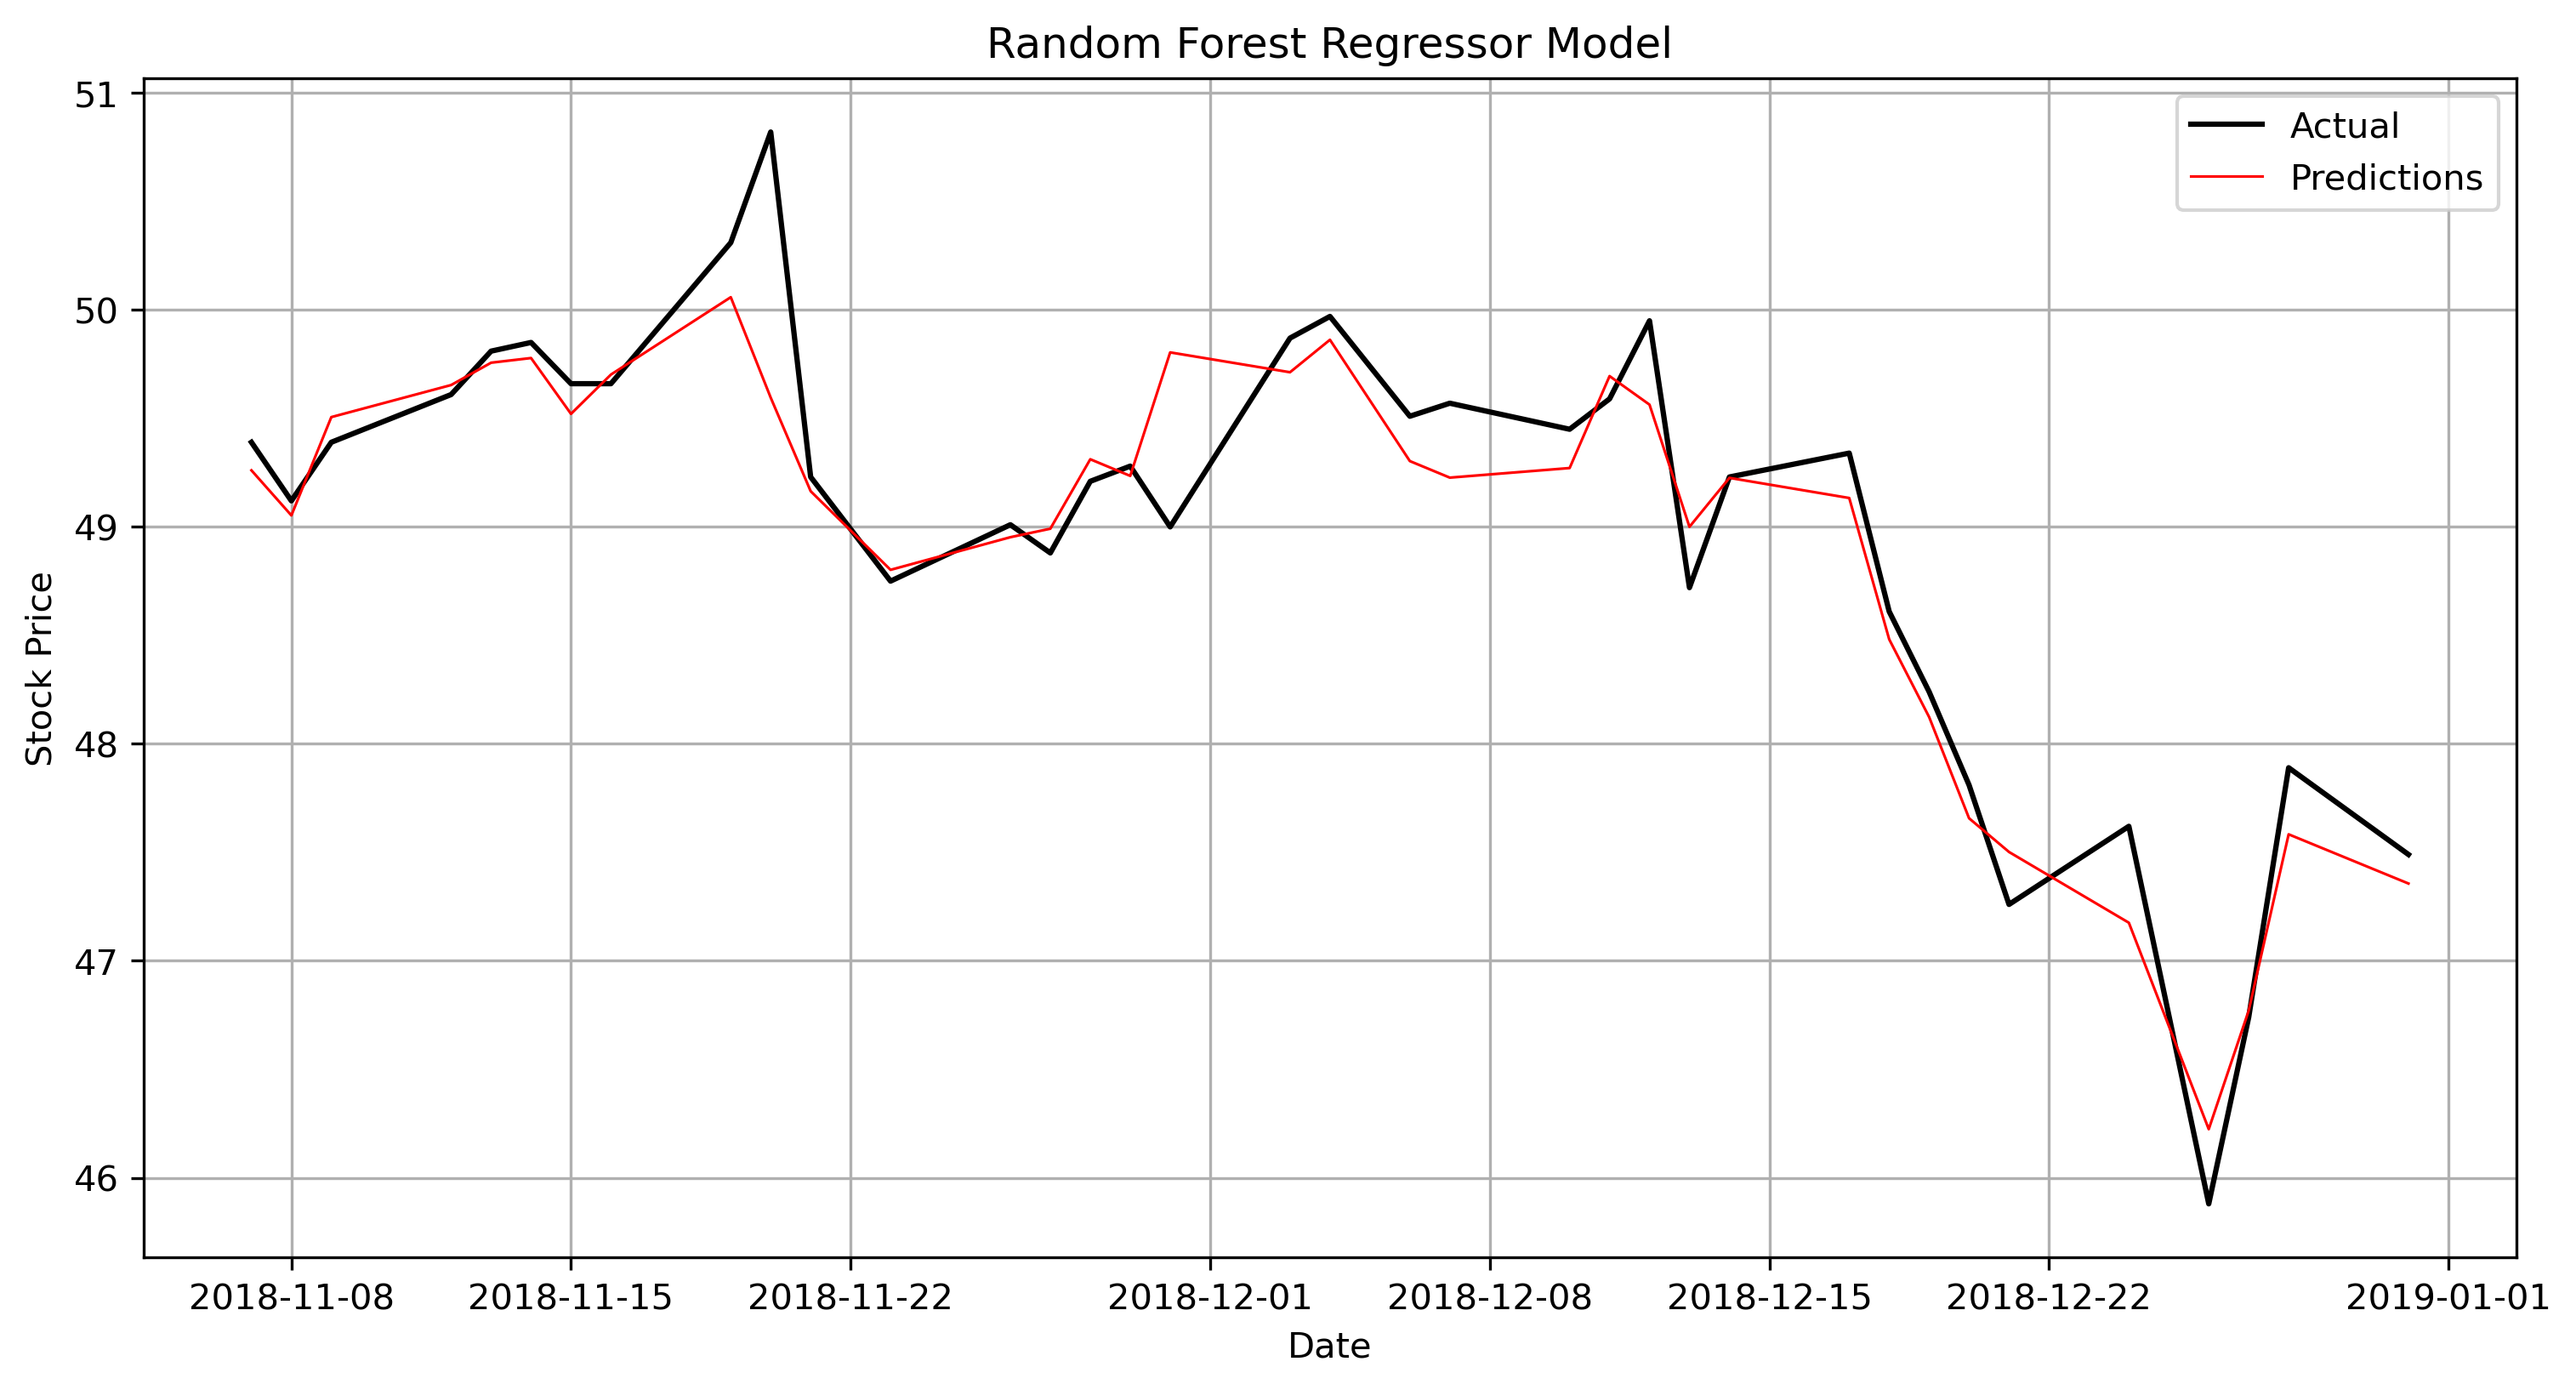

In [87]:
# Drop unnecessary columns
feature_matrix = coke.drop(columns=['Open'])
targets = coke['Open']

# Split coke into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, targets, test_size=0.2, random_state=42)

# Initialize and train the model
forest = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
forest.fit(X_train, y_train)

# Predictions
forest_predictions = forest.predict(X_test)

# Model evaluation
mae = mean_absolute_error(y_test, forest_predictions)
mse = mean_squared_error(y_test, forest_predictions)
r2 = r2_score(y_test, forest_predictions)
oob_score = forest.oob_score_

print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("R-squared: ", r2)
print("OOB score: ", oob_score)

# Plotting
plt.figure(figsize=(12,6), dpi=300)
# plt.plot(new_coke['Open'], label="Actual Future", color='#ba432e')
plt.plot(coke.index[-36:], coke['Open'].tail(36), label="Actual", color='black')
plt.plot(coke.index[-36:], forest.predict(feature_matrix.tail(36)), label="Predictions", linewidth=0.75, color='red')
plt.legend()
plt.title("Random Forest Regressor Model")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()
